# Tutorial 03: Implementing an interpolation module for an X-ray component to allow gradient descent

## Introduction

This tutorial covers how to implement an interpolation module for an X-ray component to enable **gradient-based optimization**. Analytical models are often **not reliable** for accurately modeling X-ray sources due to complex interactions in the system. Instead, we can use an **interpolation model** with some lookup tables to achieve a more accurate and flexible representation.

Many physics-based models, such as X-ray source modeling, rely on **lookup tables** generated using particle simulation tool like **Geant4**. 

We use **linear interpolation** to create a continuous function based on the lookup table values. This approach ensures that the function is **numerically differentiable**, allowing for **gradient descent optimization**.

### **What You Will Need**
- **User adjustable Parameters**: $v$ is known, like source voltage.
- **Estimated Parameters**: $a, b, c, \dots$ to be estimated or optimized.  
- **An interpolation model**: $S(E, v; a, b, c, \dots)$ that defines the spectrum or energy response.  
- **Lookup table**: Precomputed values stored as  

  $$
  \mathcal{S}[E, v; i_a, i_b, i_c, \dots]
  $$

  where:
  - $E$ represents photon energy.
  - $v$ represents source voltage.
  - $i_a, i_b, i_c, \dots$ are discrete indices for model parameters $a, b, c, \dots$.  

- **Interpolation**: Used to approximate intermediate values between the discrete lookup table entries, ensuring smooth optimization.  

### **What You Will Expect**
- How to build an **interpolation-based model**?
- Implementing the model using **PyTorch** for differentiability.
- A step-by-step guide to setting up and testing the interpolation module.

## A. Interpolation Model of Transmission Source
### A1. Background

For a transmission X-ray source, target thickness $\theta^s$ is essential for the X-ray source spectrum. We want to estimate this parameter.
For a given parameter $\theta^s$ between two discrete points $\theta_q^s$ and $\theta_{q+1}^s$, we approximate the function as:

$$
S (E, v; \theta^s) = (1 - \gamma) \mathcal{S}(E, v; \theta_q^s) + \gamma \mathcal{S}(E,\theta_{q+1}^s)
$$

where the interpolation weight $\gamma$ is given by:

$$
\gamma = \frac{\theta^s - \theta_q^s}{\theta_{q+1}^s - \theta_q^s}, \quad \text{for } \theta_q^s \leq \theta^s < \theta_{q+1}^s.
$$

This interpolation provides a **smooth approximation** of the function and is **numerically differentiable**, except at the discrete lookup points. 


### A2. Step-by Step Implementation

To build an interpolation model that supports **gradient descent**, we need three key functions:

1. **`__init__` (Initialize the Model)**  
   - Defines **voltage** as adjustable parameter and **target thickness** as optimizable parameters.  
   - Supports **single target thickness** for the CT system. If set to true, all instances of this class will use the same target thickness.   

2. **`set_src_spec_list` (Setup Lookup Table & Interpolation)**  
   - Loads **lookup table data**: discrete energies, spectra, voltages, and thicknesses.  
   - Interpolation spectrum over source voltage. 
   - Uses **bilinear interpolation (`Interp2D`)** to smoothly estimate spectra between discrete points.  

3. **`forward` (Compute Interpolated Spectrum)**  
   - Retrieves **current model parameters**.  
   - Applies **2D interpolation** on voltage and target thickness. 
   - Applies **1D interpolation (`Interp1D`)** for input energy.  
   - Ensures a **continuous, differentiable function** for **gradient-based optimization**.  

This setup enables **efficient spectral modeling and optimization** using PyTorch.  


#### **Note 1: Handling Continuous Parameters in Optimization**
In the `Transmission_Source` class, we define **voltage** and **target thickness** as optimizable parameters. These parameters are provided as tuples:  

- **`voltage`**: `(initial value, lower bound, upper bound)`  
- **`target_thickness`**: `(initial value, lower bound, upper bound)`  

##### **Key Constraints:**
- **All three values cannot be `None`**, ensuring the parameter is properly defined.
- If **lower bound == upper bound**, the parameter is **fixed** and will **not be optimized**.

To handle these parameters, we store them in a dictionary and pass them to the base class:

```python
# Build dictionary for continuous parameters
params_list = [{'voltage': voltage, 'target_thickness': target_thickness}]
super().__init__(params_list)


#### **Note 2: Handling Data Conversion in `set_src_spec_list`**  

In `set_src_spec_list`, we carefully transition data from **lists → NumPy arrays → Torch tensors** to ensure compatibility with **PyTorch's function**. 


In [1]:
import numpy as np
import torch
from xspec.models import Base_Spec_Model, prepare_for_interpolation, Interp1D, Interp2D

class Transmission_Source(Base_Spec_Model):
    def __init__(self, voltage, target_thickness, single_target_thickness):
        """
        A template source model designed specifically for reflection sources, including all necessary methods.

        Args:
            voltage (tuple): (initial value, lower bound, upper bound) for the source voltage.
                These three values cannot be all None. It will not be optimized when lower == upper.
            target_thickness (tuple): (initial value, lower bound, upper bound) for the target thickness.
                These three values cannot be all None. It will not be optimized when lower == upper.
            single_target_thickness (bool): If ture, all instances of class transmission source will be the same.
            
        """
        # Build dictionary for continous parameter.
        params_list = [{'voltage': voltage, 'target_thickness': target_thickness}]
        super().__init__(params_list)
        
        self.single_target_thickness = single_target_thickness
        if self.single_target_thickness:
            for params in self._params_list:
                params[f"{self.__class__.__name__}_target_thickness"] = params.pop(f"{self.prefix}_target_thickness")
            self._init_estimates()

    def set_src_spec_list(self, energies, src_spec_list, voltages, target_thicknesses):
        """Set source spectra for interpolation, which will be used only by forward function.

        Args:
            src_spec_list (numpy.ndarray): This array contains the reference X-ray source spectra. Each spectrum in this array corresponds to a specific combination of the target_thicknesses and one of the source voltages from src_voltage_list.
            src_voltage_list (numpy.ndarray): This is a sorted array containing the source voltages, each corresponding to a specific reference X-ray source spectrum.
            target_thicknesses (float): This value represents the target_thicknesses, expressed in um, which is used in generating the reference X-ray spectra.
        """
        # Load data
        self.energies = torch.tensor(energies, dtype=torch.float32)
        self.src_spec_list = np.array(src_spec_list)
        self.voltages = np.array(voltages)
        self.target_thicknesses = np.array(target_thicknesses)
        modified_src_spec_list = src_spec_list.copy()
        
        # Interpolation spectrum over source voltage. 
        for tti, tt in enumerate(target_thicknesses):
            modified_src_spec_list[:, tti] = prepare_for_interpolation(modified_src_spec_list[:, tti])

        # Bilinear interpolation
        V, T = torch.meshgrid(torch.tensor(self.voltages, dtype=torch.float32), torch.tensor(self.target_thicknesses, dtype=torch.float32), indexing='ij')
        self.src_spec_interp_func = Interp2D(V, T, torch.tensor(modified_src_spec_list, dtype=torch.float32))

    def forward(self, energies):
        """
        Takes X-ray energies and returns the source spectrum.

        Args:
            energies (torch.Tensor): A tensor containing the X-ray energies of a poly-energetic source in units of keV.

        Returns:
            torch.Tensor: The source response.
        """
        #  Retrieves voltage and target thickness
        voltage = self.get_params()[f"{self.prefix}_voltage"]
        if self.single_target_thickness:
            target_thickness = self.get_params()[f"{self.__class__.__name__}_target_thickness"]
        else:
            target_thickness = self.get_params()[f"{self.prefix}_target_thickness"]
        
        # Applies 2D interpolation on voltage and target thickness. 
        src_spec = self.src_spec_interp_func(voltage, target_thickness)
        
        # Build 1D interpolation function with src_spec. 
        src_interp_E_func = Interp1D(self.energies, src_spec)
        
        # Applies 1D interpolation function for input energy. 
        energies = torch.tensor(energies, dtype=torch.float32) if not isinstance(energies, torch.Tensor) else energies
        return src_interp_E_func(energies)

## A3. Usage of Transmission Source

In [2]:
import pandas as pd

def integrate_by_step(data, step_size, offset=0):
    num_elements = len(data)

    # Calculate the number of chunks
    num_chunks = (num_elements // step_size) + (1 if num_elements % step_size else 0)

    # Generate the chunks and sum their elements
    integrated_data = [sum(data[i*step_size-offset : (i)*step_size+step_size-offset]) for i in range(num_chunks)]
    
    return np.array(integrated_data)    


max_simkV=150
energies = np.linspace(1, max_simkV, max_simkV) 

# Define the kVp and Wth values for the lookup table
kvp_values = [40, 80, 150]
wth_values = [1, 3, 5, 7]

# Read data from lookup table.
data = []
df = pd.read_csv('./data/lookup_tables/Geant4_Transmission_Source_Spectra.csv', header=[0,1,2,3,4,5])
df.columns.set_names(['W_Thickness', 'Diamond_Thickness', 'Angle', 'PhysicsModel', 'Voltage', 'Energy (keV)'], inplace=True)

# Prepare lookup table data for set_src_spec_list.
for kvp in kvp_values:
    wth_data = []
    for wth in wth_values:
        # Load the data, skipping the first row
        # Specify which spectrum is read from the large csv file based on Target thickness, Apex Angle, Physics Model in Geant4, and Source Voltage.
        csv_data = df.xs(('%dum'%wth,
                          '10deg',
                          'G4EmLivermorePhysics', 
                          '%dkVp'%kvp), 
                         level=['W_Thickness', 'Angle','PhysicsModel','Voltage'], axis=1)
        # Convert bin size from 0.1 keV to 1 keV.
        sp_integral = integrate_by_step(csv_data.values[9:,0],step_size=10,offset=5)
        # Append only the y-axis data (second column)
        wth_data.append(sp_integral)


    # Stack the Wth data for this particular kVp
    data.append(np.array(wth_data))

# Convert the list to a 3D numpy array
padded_spec_table = np.array(data)
print('Lookup Table has dimension:', padded_spec_table.shape)
print(f'{len(kvp_values)}  source voltages')
print(f'{len(wth_values)}  target thicknesses')
print(f'{len(energies)}  energy bins')
padded_spec_table = np.pad(padded_spec_table, ((0, 0), (0, 0), (0, 10)), mode='constant', constant_values=0)

Lookup Table has dimension: (3, 4, 150)
3  source voltages
4  target thicknesses
150  energy bins


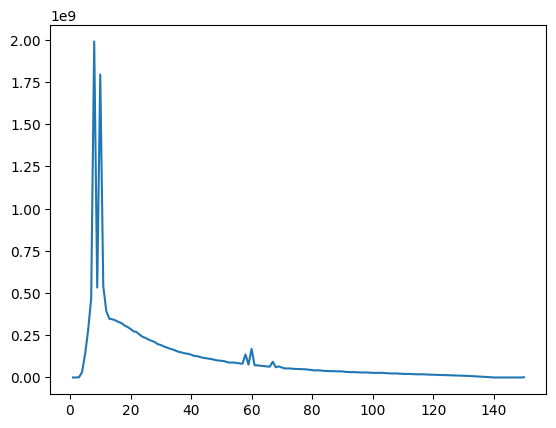

In [3]:
import matplotlib.pyplot as plt

v = 140 # source voltage in keV
theta_s = 2.5 # target thickness in um

source = Transmission_Source(voltage=(v, None, None), 
                             target_thickness=(theta_s,1,7), 
                             single_target_thickness = True)
source.set_src_spec_list(energies, padded_spec_table,kvp_values, wth_values)
ee = np.linspace(1,150,150)
ss = source(ee)

plt.plot(ee, ss.data)